# Deep Learning Project 3

### Team Members: Manamrit Singh, Farah Beche, Prashant Pokhriyal

### In this project, we will create different adversarial datasets and see how ResNet-34 (and eventually DenseNet-121) fare in classifying their images!

## Part 1: Basics

### In this section, we evaluate the pre-trained ResNet-34 model on the test dataset and record the results.

### Note that we used the synset mapping key because the class name folders did not match the JSON key given with the dataset

In [1]:
import ast
import collections
import json
import operator
import os
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm

# Load label list (401: accordion, etc.)
dataset_path = "/kaggle/input/adversialimagenetproject/TestDataSet"

with open(os.path.join(dataset_path, "labels_list.json")) as f:
    label_list = json.load(f)

# A few print statements just to verify labels list shape and contents
print(type(label_list))
print(label_list[:5])

valid_indices = {int(entry.split(":")[0]) for entry in label_list}  # 401–500

# Load index-to-synset mapping
# Note that we used the synset mapping key because the class name folders did not match the JSON key given with the dataset
with open("/kaggle/input/mapping/4a5c94eaa6dcdf29b7a62d886f540372-d25516d26be4a8d3e0aeebe9275631754b8e2c73/imagenet_label_to_wordnet_synset.txt") as f:
    raw_mapping = f.read()
index_mapping = ast.literal_eval(raw_mapping)

# Build: synset_id (e.g., n02672831) → imagenet index (e.g., 401)
synset_to_index = {}
for idx_str, entry in index_mapping.items():
    idx = int(idx_str)
    if idx in valid_indices:
        synset_id = 'n' + entry['id'].split('-')[0]
        synset_to_index[synset_id] = idx  # 401 → n02672831

<class 'list'>
['401: accordion', '402: acoustic guitar', '403: aircraft carrier', '404: airliner', '405: airship']


In [2]:
from torchvision.datasets import ImageFolder

# Needed to ensure data (subset of ImageNet) is correctly organized
class ImageNetSubfolder(ImageFolder):
    def __init__(self, root, transform=None, synset_to_index=None):
        super().__init__(root, transform=transform)
        self.synset_to_index = synset_to_index

    def __getitem__(self, index):
        path, _ = self.samples[index]
        image = self.loader(path)
        if self.transform is not None:
            image = self.transform(image)

        # Get folder name (synset ID)
        synset_id = os.path.basename(os.path.dirname(path))
        label = self.synset_to_index[synset_id]  # Use correct ImageNet index
        return image, label

In [3]:
# Using standard ResNet normalization and other transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Needed to ensure data (subset of ImageNet) is correctly organized
custom_dataset = ImageNetSubfolder(
    root=dataset_path,
    transform=transform,
    synset_to_index=synset_to_index
)

dataloader = DataLoader(custom_dataset, batch_size=32, shuffle=False)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Using ResNet34 trained on ImageNet
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model = model.to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 77.2MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
# Set to evaluation mode
model.eval()
top1_correct = 0
top5_correct = 0
total = 0

# Run inference, get predictions
with torch.no_grad():
    for images, labels in tqdm(dataloader):  # custom loader
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, top1_preds = outputs.topk(1, dim=1)
        _, top5_preds = outputs.topk(5, dim=1)

        # Top-1
        top1_correct += (top1_preds.squeeze() == labels).sum().item()

        # Top-5
        for i in range(labels.size(0)):
            if labels[i] in top5_preds[i]:
                top5_correct += 1

        total += labels.size(0)

# Record top-1 and top-5 (titled "original" because it will be compared to adversarial datasets)
original_top1 = top1_correct / total
original_top5 = top5_correct / total

print(f"Original Dataset - Top-1 Accuracy: {original_top1:.2%}")
print(f"Original Dataset - Top-5 Accuracy: {original_top5:.2%}")

100%|██████████| 16/16 [00:04<00:00,  3.43it/s]

Original Dataset - Top-1 Accuracy: 76.00%
Original Dataset - Top-5 Accuracy: 94.20%


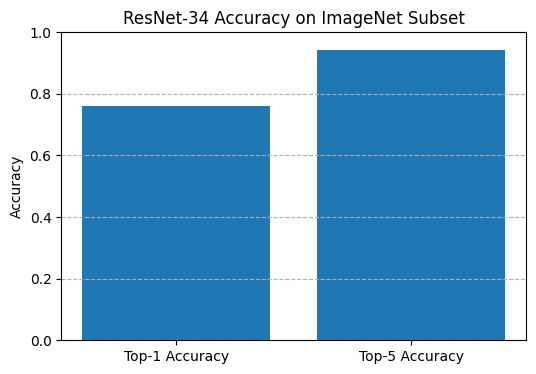

In [6]:
plt.figure(figsize=(6, 4))
plt.bar(["Top-1 Accuracy", "Top-5 Accuracy"], [original_top1, original_top5])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("ResNet-34 Accuracy on ImageNet Subset")
plt.grid(axis='y', linestyle='--')
plt.show()

100%|██████████| 16/16 [00:01<00:00,  9.31it/s]


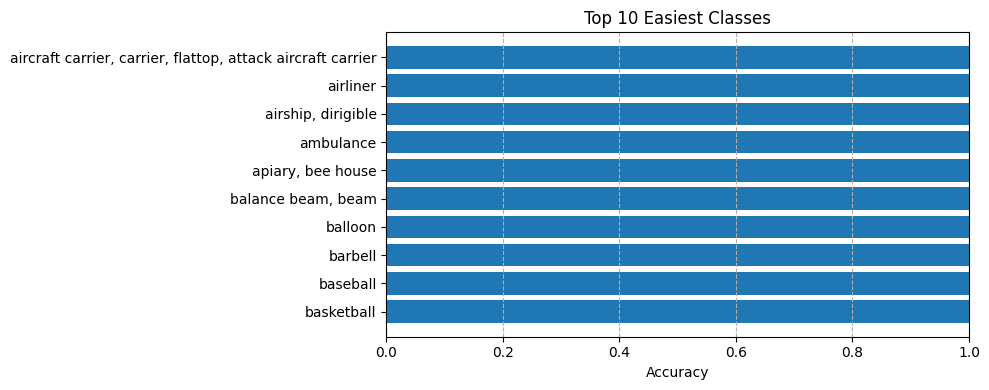

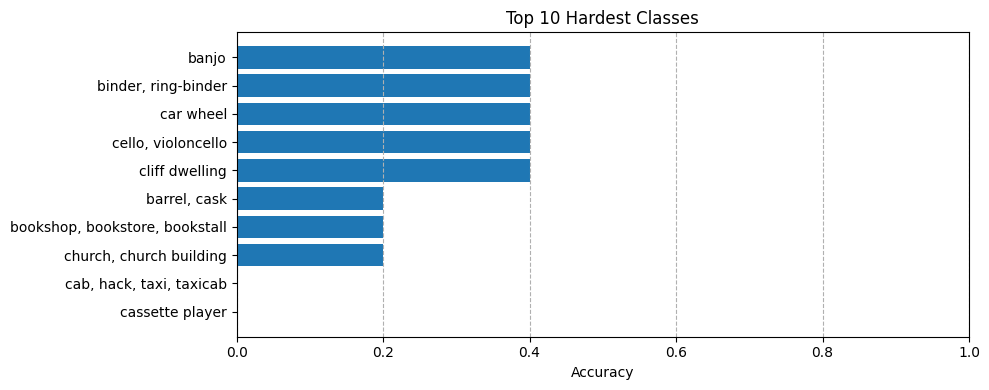

In [7]:
# Track per-class stats
class_correct = collections.defaultdict(int)
class_total = collections.defaultdict(int)

model.eval()
with torch.no_grad():
    for images, labels in tqdm(dataloader):  # Use your custom DataLoader
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.topk(1, dim=1)

        for label, pred in zip(labels, preds.squeeze()):
            label = label.item()
            pred = pred.item()
            class_total[label] += 1
            if pred == label:
                class_correct[label] += 1

# Build mapping from ImageNet index --> readable label
index_to_readable_label = {
    idx: entry['label']
    for idx, entry in index_mapping.items()
    if int(idx) in class_total
}

# Compute per-class accuracy
class_accuracies = {
    index_to_readable_label[i]: class_correct[i] / class_total[i]
    for i in class_total
}

# Sort and plot
sorted_acc = sorted(class_accuracies.items(), key=operator.itemgetter(1), reverse=True)
top10 = sorted_acc[:10]
bottom10 = sorted_acc[-10:]

def plot_classwise(acc_list, title):
    labels, accs = zip(*acc_list)
    plt.figure(figsize=(10, 4))
    plt.barh(labels, accs)
    plt.xlabel("Accuracy")
    plt.title(title)
    plt.xlim(0, 1)
    plt.grid(axis='x', linestyle='--')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

plot_classwise(top10, "Top 10 Easiest Classes")
plot_classwise(bottom10, "Top 10 Hardest Classes")

(Note that the above class investigation was performed because we were initially interested in attacking more "vulnerable" classes - this approach ended up not being used, however).

In [8]:
# Collect data from custom dataset
image_paths = [s[0] for s in custom_dataset.samples]
true_labels = [synset_to_index[os.path.basename(os.path.dirname(p))] for p in image_paths]

# Saving dataset with custom sysnet index labels (in-line with ImageNet)
data_dict = {
    "image_paths": image_paths,
    "labels": true_labels,
}
torch.save(data_dict, "imagenet_subset_dataset.pt")
print("✅ Saved to imagenet_subset_dataset.pt")

✅ Saved to imagenet_subset_dataset.pt


## Part 2: Pixel-wise attacks

### In this section, we implement FGSM for each image in the dataset, and output this dataset as "Adversarial Test Set 1."
### We'll then evaluate ResNet-34 on this new dataset and observe the results.

In [9]:
def fgsm_attack(image, label, model, epsilon):
    # Undo normalization (to pixel space)
    mean = torch.tensor([0.485, 0.456, 0.406], device=image.device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=image.device).view(1, 3, 1, 1)
    image_unnorm = image * std + mean

    image_unnorm.requires_grad = True

    # Re-normalize before forward pass
    normalized_input = (image_unnorm - mean) / std
    output = model(normalized_input)
    loss = F.cross_entropy(output, label)
    model.zero_grad()
    loss.backward()

    # FGSM step in pixel space
    grad = image_unnorm.grad.data
    perturbed_unnorm = image_unnorm + epsilon * grad.sign()
    perturbed_unnorm = torch.clamp(perturbed_unnorm, 0, 1)

    # Re-normalize for evaluation
    perturbed_normalized = (perturbed_unnorm - mean) / std

    return perturbed_normalized.detach(), perturbed_unnorm.detach()

In [10]:
epsilon = 0.02
mean = torch.tensor([0.485, 0.456, 0.406], device='cuda').view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225], device='cuda').view(1, 3, 1, 1)

orig_images = []
adv_pixel_images = []
adv_images = []
adv_labels = []

for images, labels in dataloader:
    images, labels = images.cuda(), labels.cuda()
    for i in range(images.size(0)):
        image = images[i].unsqueeze(0)
        label = labels[i].unsqueeze(0)

        # Denormalize original image
        image_unnorm = image * std + mean
        orig_images.append(image_unnorm.cpu().detach())  # Save as [0,1] range image

        # Get adversarial image
        adv_image, adv_pixel = fgsm_attack(image, label, model, epsilon)
        adv_images.append(adv_image.cpu())
        # Save unnormalized version of the adversarial image
        adv_pixel_images.append(adv_pixel.cpu())
        # Save label
        adv_labels.append(label.cpu())

In [11]:
adv_images_tensor = torch.cat(adv_images)
adv_labels_tensor = torch.cat(adv_labels)

torch.save({
    "adv_images": adv_images_tensor,
    "adv_labels": adv_labels_tensor
}, "/kaggle/working/adversarial_test_set_1.pt")

In [12]:
# Normalize already done, no extra transform needed
adv_dataset_1 = TensorDataset(adv_images_tensor, adv_labels_tensor)
adv_loader_1 = DataLoader(adv_dataset_1, batch_size=32, shuffle=False)

def evaluate(model, dataloader, topk=(1, 5)):
    correct_top1 = 0
    correct_top5 = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, top5_preds = outputs.topk(5, dim=1)

            correct_top1 += (top5_preds[:, 0] == labels).sum().item()
            correct_top5 += sum([labels[i] in top5_preds[i] for i in range(len(labels))])
            total += labels.size(0)

    return correct_top1 / total, correct_top5 / total

adv1_top1, adv1_top5 = evaluate(model, adv_loader_1)
print(f"Adversarial Dataset 1 - Top-1 Accuracy: {adv1_top1:.2%}")
print(f"Adversarial Dataset 1 - Top-5 Accuracy: {adv1_top5:.2%}")

Adversarial Dataset 1 - Top-1 Accuracy: 3.40%
Adversarial Dataset 1 - Top-5 Accuracy: 21.20%


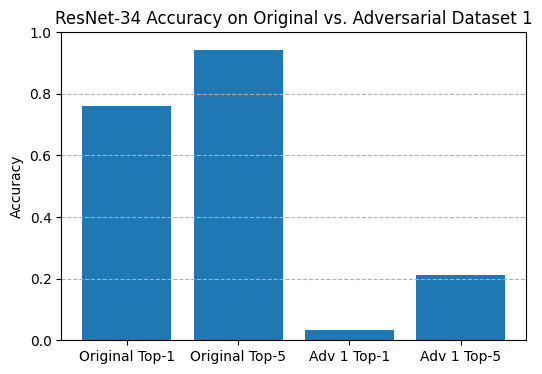

In [13]:
plt.figure(figsize=(6, 4))
plt.bar(["Original Top-1", "Original Top-5", "Adv 1 Top-1", "Adv 1 Top-5"], [original_top1, original_top5, adv1_top1, adv1_top5])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("ResNet-34 Accuracy on Original vs. Adversarial Dataset 1")
plt.grid(axis='y', linestyle='--')
plt.show()

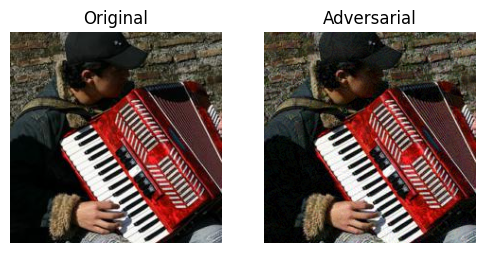

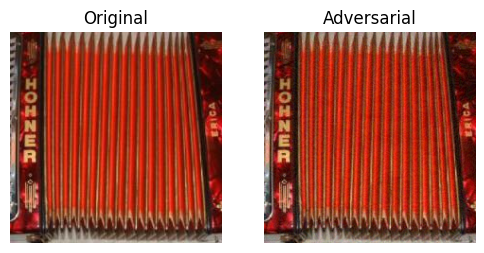

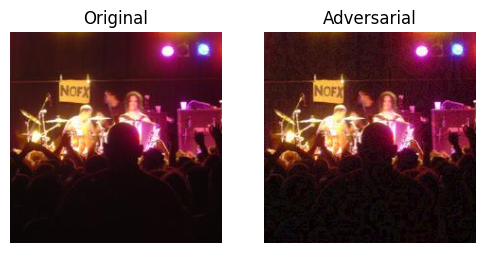

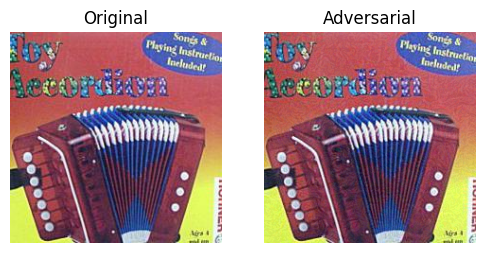

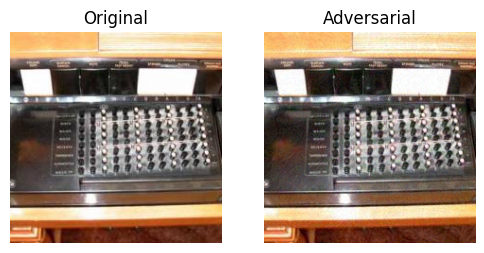

In [14]:
# Redefine normalization constants
mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]

# Unnormalize inside visualization
def show_comparison(orig, adv, idx):
    # Convert CHW to HWC and NumPy format
    orig_img = orig[idx].permute(1, 2, 0).numpy()
    adv_img = adv[idx].permute(1, 2, 0).numpy()

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(np.clip(orig_img, 0, 1))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Adversarial")
    plt.imshow(np.clip(adv_img, 0, 1))
    plt.axis("off")
    plt.show()

# Compare Original and Adversarial images
show_comparison(torch.cat(orig_images), torch.cat(adv_pixel_images), idx=0)
show_comparison(torch.cat(orig_images), torch.cat(adv_pixel_images), idx=1)
show_comparison(torch.cat(orig_images), torch.cat(adv_pixel_images), idx=2)
show_comparison(torch.cat(orig_images), torch.cat(adv_pixel_images), idx=3)
show_comparison(torch.cat(orig_images), torch.cat(adv_pixel_images), idx=4)

## Part 3: Improved Attack

### Time to attack the ResNet-34 model in a new way: PGD, or Projected Gradient Descent.

### Projected Gradient Descent differs from FGSM in the sense that it performs multiple small steps (all the while ensuring the perturbation remains within our defined bounds) in the gradient direction rather than a single large step, hopefully leading to better adversarial images.

### After creating a new dataset, we'll save it as “Adversarial Test Set 2” and then evaluate ResNet-34 performance on the dataset.

In [15]:
def pgd_attack(image, label, model, epsilon=0.02, alpha=0.005, num_iter=5):
    mean = torch.tensor([0.485, 0.456, 0.406], device=image.device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=image.device).view(1, 3, 1, 1)

    # Undo normalization to bring back to pixel space
    image_unnorm = image * std + mean
    # Detach original unnormalized image (will use for verifying we're within epsilon limit)
    orig_image = image_unnorm.detach()

    # Create a clone of the unnormalized image that requires gradients
    adv_image = image_unnorm.clone().detach().requires_grad_(True)

    for _ in range(num_iter):
        # Renormalize adversarial image
        normalized = (adv_image - mean) / std
        # Get model prediction for normalized adversarial image, then calculate loss and gradient
        output = model(normalized)
        loss = F.cross_entropy(output, label)
        model.zero_grad()
        loss.backward()
        grad = adv_image.grad.data

        # Update adversarial image in the direction of the sign of the gradient
        adv_image = adv_image + alpha * grad.sign()
        # Project the perturbation to be within epsilon
        delta = torch.clamp(adv_image - orig_image, min=-epsilon, max=epsilon)
        # Apply perturbation to the original image, set pixel values between [0, 1]
        adv_image = torch.clamp(orig_image + delta, 0, 1).detach().requires_grad_(True)

    # Re-normalize the final adversarial image for potential evaluation with the model
    final_input = (adv_image - mean) / std
    # Return normalized adversarial input and unnormalized adversarial image (detached from the graph)
    return final_input.detach(), adv_image.detach()

In [16]:
orig_images_2 = []
adv_inputs_2 = []
adv_pixel_images_2 = []
adv_labels_2 = []

for images, labels in dataloader:
    images, labels = images.cuda(), labels.cuda()
    for i in range(images.size(0)):
        image = images[i].unsqueeze(0)
        label = labels[i].unsqueeze(0)

        # Save unnormalized clean image
        mean = torch.tensor([0.485, 0.456, 0.406], device='cuda').view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device='cuda').view(1, 3, 1, 1)
        image_unnorm = image * std + mean
        orig_images_2.append(image_unnorm.cpu())

        adv_input, adv_pixel = pgd_attack(image, label, model,
                                          epsilon=0.02, alpha=0.005, num_iter=5)
        adv_inputs_2.append(adv_input.cpu())
        adv_pixel_images_2.append(adv_pixel.cpu())
        adv_labels_2.append(label.cpu())

In [17]:
torch.save({
    "adv_inputs": torch.cat(adv_inputs_2),
    "adv_pixel_images": torch.cat(adv_pixel_images_2),
    "adv_labels": torch.cat(adv_labels_2)
}, "/kaggle/working/adversarial_test_set_2.pt")

In [18]:
adv_dataset_2 = TensorDataset(torch.cat(adv_inputs_2), torch.cat(adv_labels_2))
adv_loader_2 = DataLoader(adv_dataset_2, batch_size=32, shuffle=False)

adv2_top1, adv2_top5 = evaluate(model, adv_loader_2)
print(f"Adversarial Test Set 2 - Top-1 Accuracy: {adv2_top1:.2%}")
print(f"Adversarial Test Set 2 - Top-5 Accuracy: {adv2_top5:.2%}")

Adversarial Test Set 2 - Top-1 Accuracy: 0.00%
Adversarial Test Set 2 - Top-5 Accuracy: 2.80%


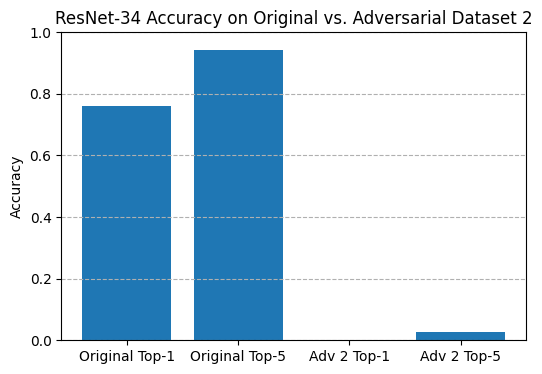

In [19]:
plt.figure(figsize=(6, 4))
plt.bar(["Original Top-1", "Original Top-5", "Adv 2 Top-1", "Adv 2 Top-5"], [original_top1, original_top5, adv2_top1, adv2_top5])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("ResNet-34 Accuracy on Original vs. Adversarial Dataset 2")
plt.grid(axis='y', linestyle='--')
plt.show()

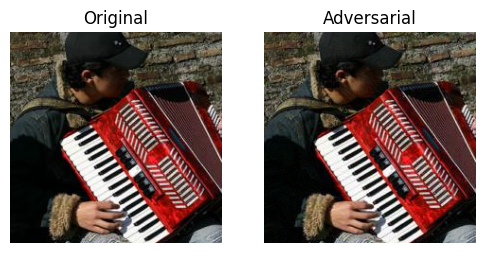

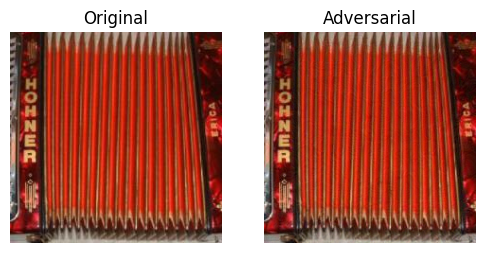

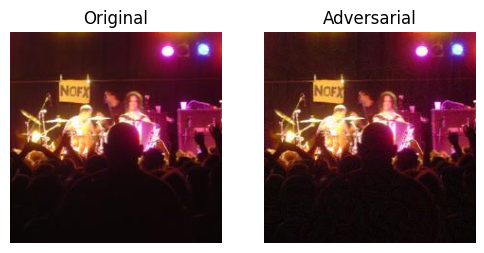

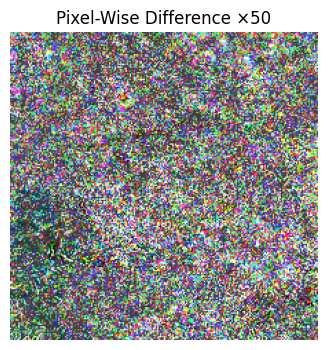

In [20]:
def show_difference(orig, adv, idx, amplify=50):
    diff = (adv[idx] - orig[idx]).abs()  # shape: [3, H, W]
    diff = diff.permute(1, 2, 0).numpy()  # to [H, W, 3] for plt
    diff = np.clip(diff * amplify, 0, 1)  # enhance visibility, keep valid RGB range

    plt.figure(figsize=(4, 4))
    plt.imshow(diff)
    plt.title(f"Pixel-Wise Difference ×{amplify}")
    plt.axis("off")
    plt.show()

# Compare Original and Adversarial images
show_comparison(torch.cat(orig_images_2), torch.cat(adv_pixel_images_2), idx=0)
show_comparison(torch.cat(orig_images_2), torch.cat(adv_pixel_images_2), idx=1)
show_comparison(torch.cat(orig_images_2), torch.cat(adv_pixel_images_2), idx=2)
show_difference(torch.cat(orig_images_2), torch.cat(adv_pixel_images_2), idx=0)

## Part 4: Patch Attacks

### For this section, we'll take our best performing attack thus far (PGD) and apply it to a 64x64, centered patch of each image.

## Important Note: Although we were initially adding a 32x32 patch and applying it to a random location (as stated in the instructions PDF), we switched to a 64x64 and at a fixed location after seeing the professor's comments on Slack that these two forms of experimentation were acceptable.

### After creating a new dataset, we'll save it as “Adversarial Test Set 3” and then evaluate ResNet-34 performance on the dataset.

In [21]:
# Note that epsilon is increased for this attack, since we're only modifying a random subsection of the image
def pgd_patch_attack(image, label, model, epsilon=0.05, alpha=0.005, num_iter=5, patch_size=32):
    mean = torch.tensor([0.485, 0.456, 0.406], device=image.device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=image.device).view(1, 3, 1, 1)

    # Undo normalization to bring pixel values back to [0, 1] range
    image_unnorm = image * std + mean
    # Detach original unnormalized image (will use for verifying we're within epsilon limit)
    orig_image = image_unnorm.detach()
    batch_size, channels, height, width = image_unnorm.shape

    # Create a clone of the unnormalized image that requires gradients
    adv_image = image_unnorm.clone().detach().requires_grad_(True)

    # Putting patch in the Center
    # Objects in images are more likely to be towards the middle than the sides, so it seems like the best way to try to fool the model
    top = (height - patch_size) // 2
    left = (width - patch_size) // 2
    bottom = top + patch_size
    right = left + patch_size
    
    for _ in range(num_iter):
        # Create boolean mask so we can restrict the patch to the center
        mask = torch.zeros_like(adv_image).bool()
        mask[:, :, top:bottom, left:right] = True

        # Renormalize adversarial image
        normalized = (adv_image - mean) / std
        # Get model prediction for normalized adversarial image, then calculate loss and gradient
        output = model(normalized)
        loss = F.cross_entropy(output, label)
        model.zero_grad()
        loss.backward()
        grad = adv_image.grad.data

        # Calculate gradient update for the patch region; get gradient within the mask and scale it by alpha
        adv_image_grad_patch = alpha * grad[mask].sign().reshape(batch_size, channels, patch_size, patch_size)
        # Need to create a copy here to avoid in-place modification error
        new_adv_image = adv_image.clone()
        # Update the pixel values within the center patch of the new adversarial image by adding the gradient update.
        new_adv_image[:, :, top:bottom, left:right] = adv_image[:, :, top:bottom, left:right] + adv_image_grad_patch
        # Update adversarial image to the newly modified version
        adv_image = new_adv_image.detach().requires_grad_(True)

        # Calculate the difference (delta) between the current adversarial patch and the original patch.
        patch_delta = adv_image[:, :, top:bottom, left:right] - orig_image[:, :, top:bottom, left:right]
        clipped_delta = torch.clamp(patch_delta, min=-epsilon, max=epsilon)
        # Create another copy of the adversarial image to avoid in-place modification error
        new_adv_image_clamped = adv_image.clone()
        # Apply the clipped delta to the original image's patch region and clamp the pixel values to [0, 1] range
        new_adv_image_clamped[:, :, top:bottom, left:right] = torch.clamp(orig_image[:, :, top:bottom, left:right] + clipped_delta, 0, 1)
        adv_image = new_adv_image_clamped.detach().requires_grad_(True) # Update adv_image

        if adv_image.grad is not None:
            adv_image.grad.zero_()

    # Renormalize the final adversarial image
    final_input = (adv_image - mean) / std
    # Return both normalized adversarial input and unnormalized adversarial image
    return final_input.detach(), adv_image.detach()

In [22]:
orig_images_3 = []
adv_inputs_3 = []
adv_pixel_images_3 = []
adv_labels_3 = []

for images, labels in dataloader:
    images, labels = images.cuda(), labels.cuda()
    for i in range(images.size(0)):
        image = images[i].unsqueeze(0)
        label = labels[i].unsqueeze(0)

        # Save unnormalized clean image
        mean = torch.tensor([0.485, 0.456, 0.406], device='cuda').view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device='cuda').view(1, 3, 1, 1)
        image_unnorm = image * std + mean
        orig_images_3.append(image_unnorm.cpu())

        # Setting epsilon to 0.4, and alpha to 0.4/10 = 0.04
        adv_input, adv_pixel = pgd_patch_attack(image, label, model, 
                                                epsilon=0.4, alpha=0.04, num_iter=10, patch_size=64)
        adv_inputs_3.append(adv_input.cpu())
        adv_pixel_images_3.append(adv_pixel.cpu())
        adv_labels_3.append(label.cpu())

In [23]:
torch.save({
    "adv_inputs": torch.cat(adv_inputs_3),
    "adv_pixel_images": torch.cat(adv_pixel_images_3),
    "adv_labels": torch.cat(adv_labels_3)
}, "/kaggle/working/adversarial_test_set_3.pt")

In [24]:
adv_dataset_3 = TensorDataset(torch.cat(adv_inputs_3), torch.cat(adv_labels_3))
adv_loader_3 = DataLoader(adv_dataset_3, batch_size=32, shuffle=False)

adv3_top1, adv3_top5 = evaluate(model, adv_loader_3)
print(f"Adversarial Test Set 3 - Top-1 Accuracy: {adv3_top1:.2%}")
print(f"Adversarial Test Set 3 - Top-5 Accuracy: {adv3_top5:.2%}")

Adversarial Test Set 3 - Top-1 Accuracy: 1.00%
Adversarial Test Set 3 - Top-5 Accuracy: 25.60%


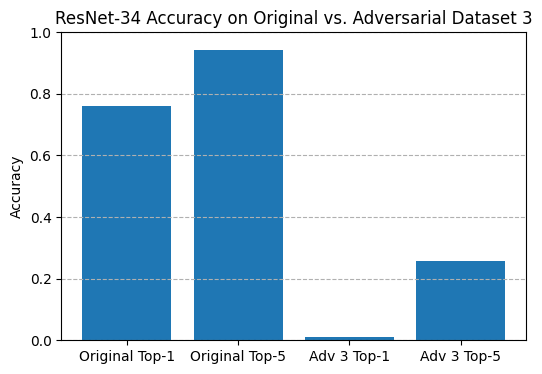

In [25]:
plt.figure(figsize=(6, 4))
plt.bar(["Original Top-1", "Original Top-5", "Adv 3 Top-1", "Adv 3 Top-5"], [original_top1, original_top5, adv3_top1, adv3_top5])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("ResNet-34 Accuracy on Original vs. Adversarial Dataset 3")
plt.grid(axis='y', linestyle='--')
plt.show()

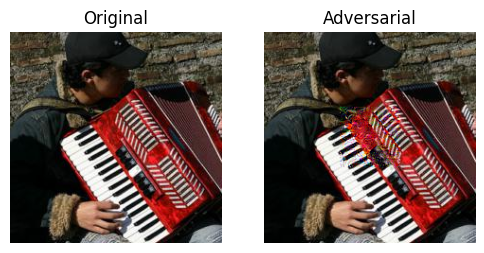

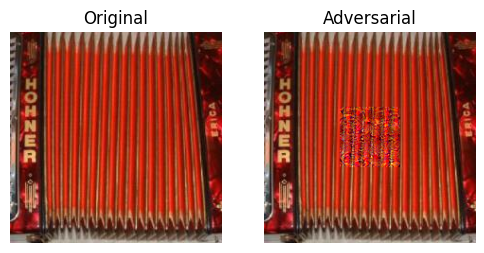

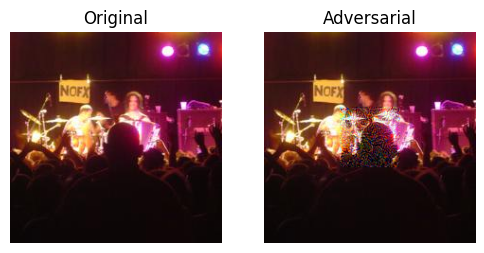

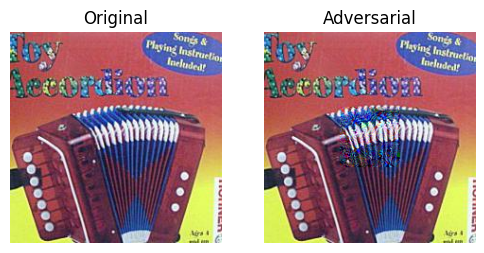

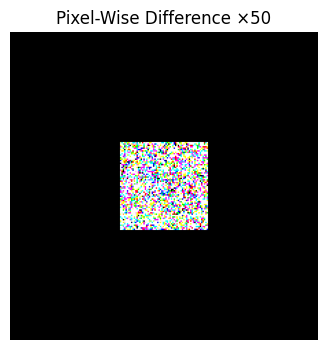

In [26]:
# Compare Original and Adversarial images
show_comparison(torch.cat(orig_images_3), torch.cat(adv_pixel_images_3), idx=0)
show_comparison(torch.cat(orig_images_3), torch.cat(adv_pixel_images_3), idx=1)
show_comparison(torch.cat(orig_images_3), torch.cat(adv_pixel_images_3), idx=2)
show_comparison(torch.cat(orig_images_3), torch.cat(adv_pixel_images_3), idx=3)
# In the final image below, note how the pixel difference is restricted to the central patch
show_difference(torch.cat(orig_images_3), torch.cat(adv_pixel_images_3), idx=0)

## Part 4.5: Graphing our Results Thus Far

### Before moving on to Part 5, let's compare the ResNet-34 performance across the different datasets, both original and adversarial.

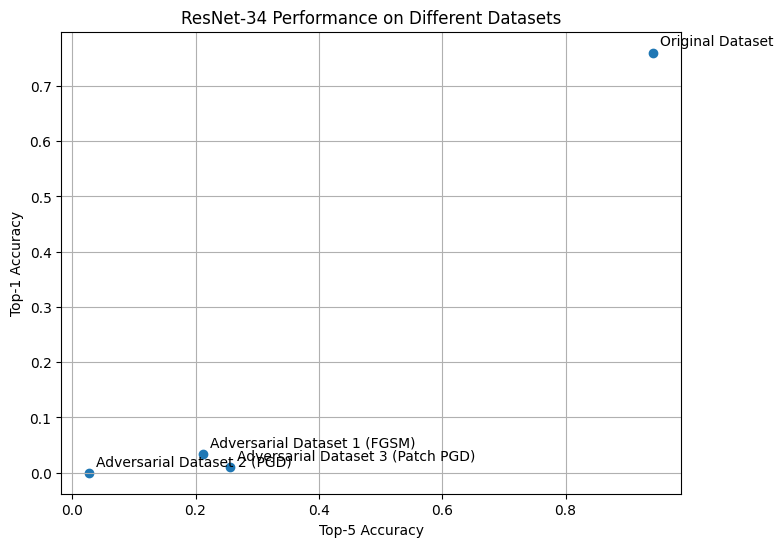

In [27]:
# Comparing ResNet performance against all datasets
x = [original_top5, adv1_top5, adv2_top5, adv3_top5]
y = [original_top1, adv1_top1, adv2_top1, adv3_top1]
labels = ['Original Dataset', 'Adversarial Dataset 1 (FGSM)', 'Adversarial Dataset 2 (PGD)', 'Adversarial Dataset 3 (Patch PGD)']

plt.figure(figsize=(8, 6))
plt.scatter(x, y)

for i, label in enumerate(labels):
    plt.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(5, 5), ha='left')

plt.xlabel('Top-5 Accuracy')
plt.ylabel('Top-1 Accuracy')
plt.title('ResNet-34 Performance on Different Datasets')
plt.grid(True)
plt.show()

### It's worth noting the dropoff from Original Dataset to Adversarial Dataset 3 is almost as much as the dropoff to Datasets 1-2.

### However, this degree of a dropoff would not be possible without us centering the patch as opposed to it being placed in a random location (note the professor said choosing specific patch placement was acceptable via Slack).

## Part 5: Transferring attacks

### We'll now be using a different pre-trained network (DenseNet-121) for classification on all of the adversarial datasets we've created.

### We'll then compare performance between the model's classification of the different datsets.


In [28]:
# Switching to DenseNet-121 trained on ImageNet
dense_net_model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
dense_net_model = dense_net_model.to(device)
dense_net_model.eval()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 160MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [29]:
# DenseNet121 classifying images from original dataset
original_top_1, original_top_5 = evaluate(dense_net_model, dataloader)
print(f"Original Model: Top-1 Accuracy: {original_top_1:.2%}")
print(f"Original Model: Top-5 Accuracy: {original_top_5:.2%}")

Original Model: Top-1 Accuracy: 74.80%
Original Model: Top-5 Accuracy: 93.60%


In [30]:
# DenseNet121 classifying images of Adversarial Model 1 
adv1_top_1, adv1_top_5 = evaluate(dense_net_model, adv_loader_1)
print(f"Adversarial Dataset 1: Top-1 Accuracy: {adv1_top_1:.2%}")
print(f"Adversarial Dataset 1: Top-5 Accuracy: {adv1_top_5:.2%}")

Adversarial Dataset 1: Top-1 Accuracy: 45.60%
Adversarial Dataset 1: Top-5 Accuracy: 76.20%


In [31]:
# DenseNet121 classifying images of Adversarial Model 2
adv2_top_1, adv2_top_5 = evaluate(dense_net_model, adv_loader_2)
print(f"Adversarial Dataset 2: Top-1 Accuracy: {adv2_top_1:.2%}")
print(f"Adversarial Dataset 2: Top-5 Accuracy: {adv2_top_5:.2%}")

Adversarial Dataset 2: Top-1 Accuracy: 44.20%
Adversarial Dataset 2: Top-5 Accuracy: 78.00%


In [32]:
# DenseNet121 classifying images of Adversarial Model 3
adv3_top_1, adv3_top_5 = evaluate(dense_net_model, adv_loader_3)
print(f"Adversarial Dataset 3: Top-1 Accuracy: {adv3_top_1:.2%}")
print(f"Adversarial Dataset 3: Top-5 Accuracy: {adv3_top_5:.2%}")

Adversarial Dataset 3: Top-1 Accuracy: 58.00%
Adversarial Dataset 3: Top-5 Accuracy: 84.80%


Plotting the results with Top-1 Accuracy on the y axis, Top-5 Accuracy on the x-axis

In general, the closer a dataset is to the top right, the better the DenseNet was at classifying the images of that dataset.

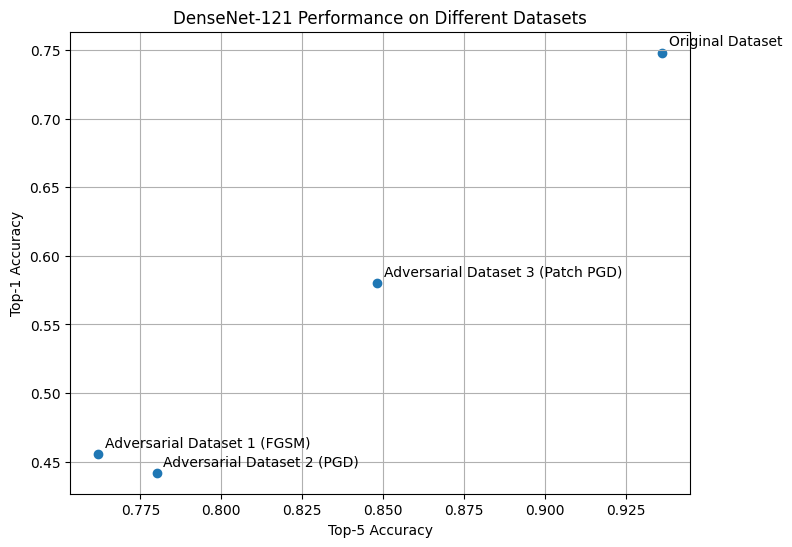

In [33]:
# Comparing DenseNet performance against all datasets
x = [original_top_5, adv1_top_5, adv2_top_5, adv3_top_5]
y = [original_top_1, adv1_top_1, adv2_top_1, adv3_top_1]
labels = ['Original Dataset', 'Adversarial Dataset 1 (FGSM)', 'Adversarial Dataset 2 (PGD)', 'Adversarial Dataset 3 (Patch PGD)']

plt.figure(figsize=(8, 6))
plt.scatter(x, y)

for i, label in enumerate(labels):
    plt.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(5, 5), ha='left')

plt.xlabel('Top-5 Accuracy')
plt.ylabel('Top-1 Accuracy')
plt.title('DenseNet-121 Performance on Different Datasets')
plt.grid(True)
plt.show()

### Observations & Trends Observed

Unsurprisingly, DenseNet-121 performs better on the adversarial images than ResNet-34 did (which makes sense, since the perturbations were based off of finding features that ResNet34 was particularly sensitive to).

However, there are a few things that are interesting here, the first of which is that **whether classification was done by ResNet-34 or DenseNet-121, the top-1% accuracy on full-image PGD was worse than the top-1% accuracy on full-image FGSM.**

As for the PGD patch images: while the performance of ResNet34 on Adversarial Dataset 3 was almost comparable to the performance of ResNet34 on Adversarial Datasets 1 and 2, the difference has become more dramatic in this new graph. 

One possibility as to why this is the case may be because DenseNets are designed to rely more on distributed feature representations across the entire image, so maybe it is more resilient to a targeted patch attack (https://pmc.ncbi.nlm.nih.gov/articles/PMC9060995). Further investigation may be needed to verify this.

### Lessons Learned & Mitigating Transferability

1. The success of adversarial images / attacks is often highly specific to the particular model they're intended to fool. In other words, transferability from model to model is not always high.

2. Therefore, if I were a malicious actor, it would make sense to be well aware of the architecture of the model I'm intending to defeat.

3. **Mitigating Transferability:**  On the flip side, if I'm designing the architecture of a machine learning model, I should A) keep these attack methods in mind so I can cleverly design an architecture that is less susceptible to attacks (perhaps one that relies on more features so it cannot be defeated by a particular targeted perturbation), and B) test out my model on datasets modified via FGSM, PGD, and so on.

4. Given the apparent increased resilience of DenseNet121 on the patch images relative to its performance on the fully perturbed images, the degree to which a model relies on distributed feature representations across an image for its classification may be indicative of how resilient it is to the attacks we've seen in this project. Further investigation may be needed to verify this.